In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

PRED_PATH = "../models/st1_deberta_v3_base_len128/val_predictions.csv"  # schimbă cu outdir-ul tău
OUTDIR = "analysis_len128"
os.makedirs(OUTDIR, exist_ok=True)

df = pd.read_csv(PRED_PATH)
df.head(), df.columns


(   user_id  text_id            timestamp  collection_phase  is_words  valence  \
 0       26     1554  2022-03-11 20:52:26                 2     False      0.0   
 1      169     4287  2024-08-09 17:01:20                 7     False     -2.0   
 2       71     4971  2024-09-02 17:05:44                 7      True      0.0   
 3       90      606  2024-10-21 22:08:34                 7     False     -2.0   
 4       76     5084  2024-11-21 17:08:50                 7     False      1.0   
 
    arousal  pred_valence  pred_arousal  
 0      1.0      0.267403      0.865064  
 1      0.0     -0.762358      0.886056  
 2      1.0      1.361953      0.847891  
 3      2.0     -1.589569      0.749431  
 4      1.0      1.795309      0.766145  ,
 Index(['user_id', 'text_id', 'timestamp', 'collection_phase', 'is_words',
        'valence', 'arousal', 'pred_valence', 'pred_arousal'],
       dtype='object'))

In [3]:
df = df.dropna(subset=["user_id", "timestamp", "valence", "arousal", "pred_valence", "pred_arousal"]).copy()

df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df = df.dropna(subset=["timestamp"]).copy()

for c in ["valence","arousal","pred_valence","pred_arousal"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
df = df.dropna(subset=["valence","arousal","pred_valence","pred_arousal"]).copy()

df.shape


(277, 9)

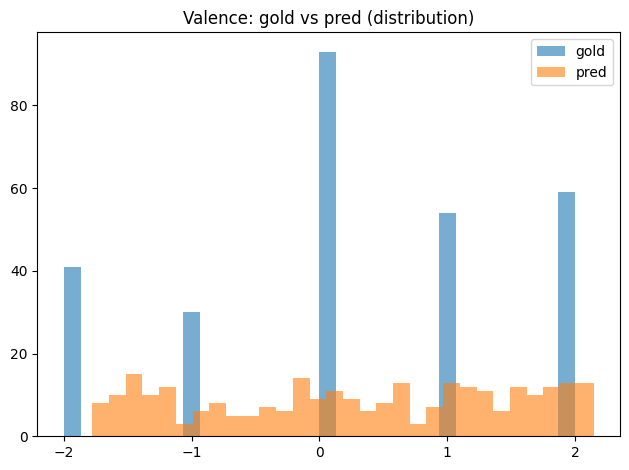

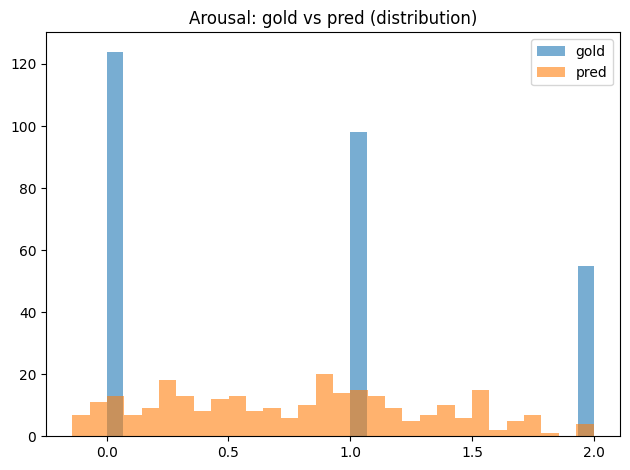

In [4]:
def hist_overlay(gold, pred, title, outpath):
    plt.figure()
    plt.hist(gold, bins=30, alpha=0.6, label="gold")
    plt.hist(pred, bins=30, alpha=0.6, label="pred")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.show()

hist_overlay(df["valence"], df["pred_valence"], "Valence: gold vs pred (distribution)", f"{OUTDIR}/hist_valence.png")
hist_overlay(df["arousal"], df["pred_arousal"], "Arousal: gold vs pred (distribution)", f"{OUTDIR}/hist_arousal.png")


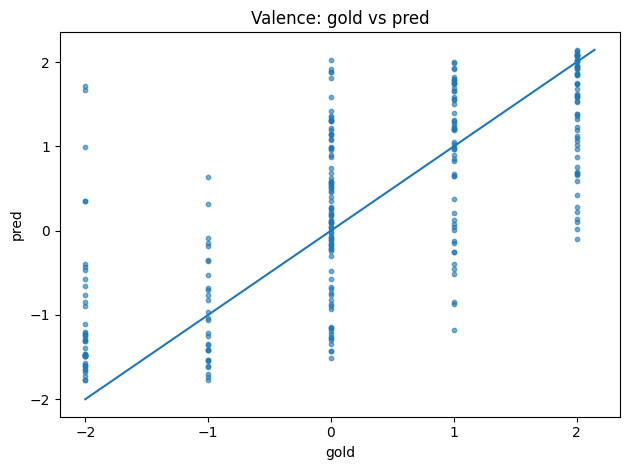

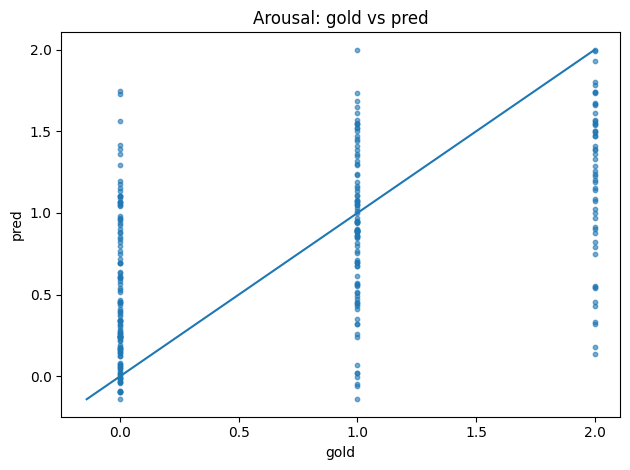

In [5]:
def scatter_gold_pred(gold, pred, title, outpath):
    plt.figure()
    plt.scatter(gold, pred, s=10, alpha=0.6)
    mn = min(gold.min(), pred.min())
    mx = max(gold.max(), pred.max())
    plt.plot([mn, mx], [mn, mx])
    plt.xlabel("gold")
    plt.ylabel("pred")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.show()

scatter_gold_pred(df["valence"], df["pred_valence"], "Valence: gold vs pred", f"{OUTDIR}/scatter_valence.png")
scatter_gold_pred(df["arousal"], df["pred_arousal"], "Arousal: gold vs pred", f"{OUTDIR}/scatter_arousal.png")


In [6]:
def group_stats(frame, name):
    return pd.Series({
        "n": len(frame),
        "gold_val_mean": frame["valence"].mean(),
        "pred_val_mean": frame["pred_valence"].mean(),
        "gold_aro_mean": frame["arousal"].mean(),
        "pred_aro_mean": frame["pred_arousal"].mean(),
        "val_abs_err": (frame["pred_valence"] - frame["valence"]).abs().mean(),
        "aro_abs_err": (frame["pred_arousal"] - frame["arousal"]).abs().mean(),
    }, name=name)

stats_all = group_stats(df, "all")
stats_words = group_stats(df[df["is_words"] == True], "is_words=True")
stats_essays = group_stats(df[df["is_words"] == False], "is_words=False")

pd.concat([stats_all, stats_words, stats_essays], axis=1)


,all,is_words=True,is_words=False
n,277.000000,147.000000,130.000000
gold_val_mean,0.216606,0.299320,0.123077
pred_val_mean,0.291181,0.409215,0.157712
gold_aro_mean,0.750903,0.707483,0.800000
pred_aro_mean,0.782149,0.719846,0.852601
val_abs_err,0.724926,0.745187,0.702016
aro_abs_err,0.511206,0.459545,0.569622


In [7]:
top_users = df["user_id"].value_counts().head(3).index.tolist()
top_users

[2, 40, 33]

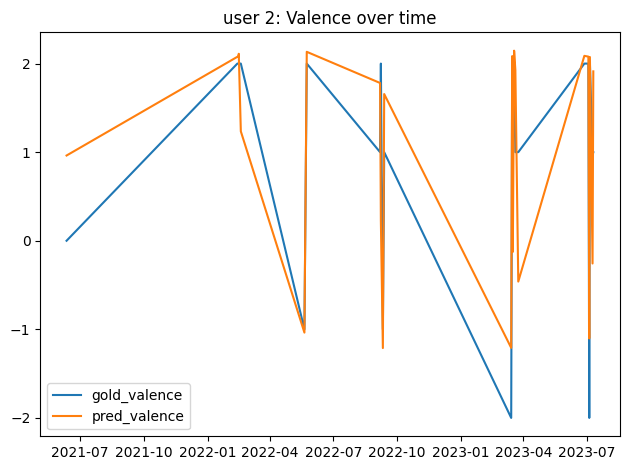

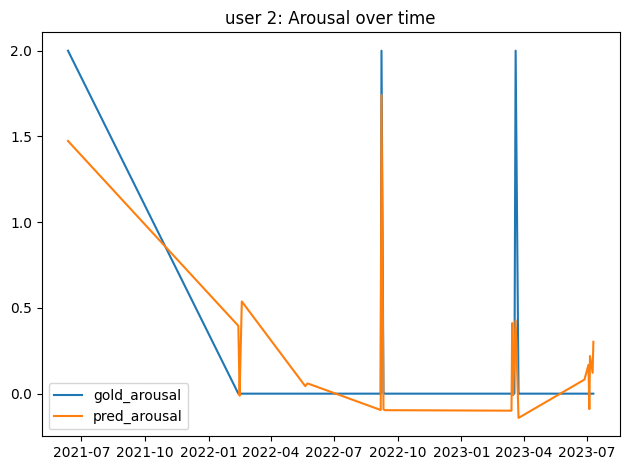

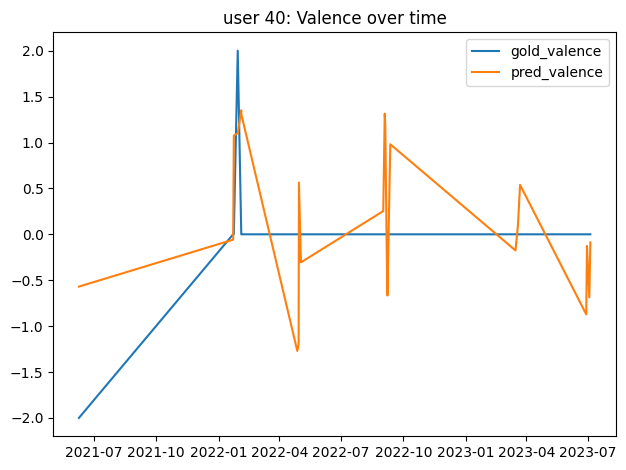

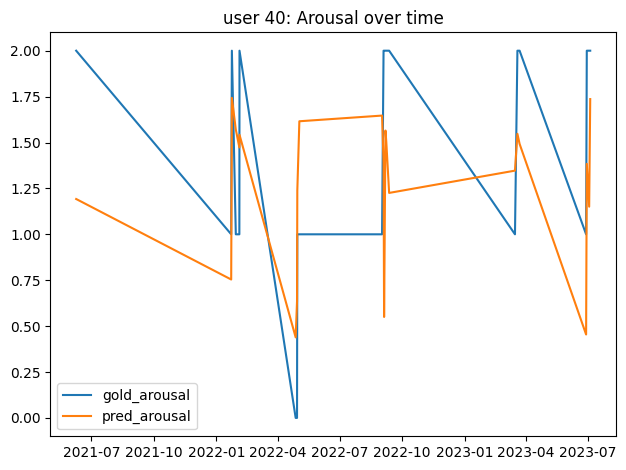

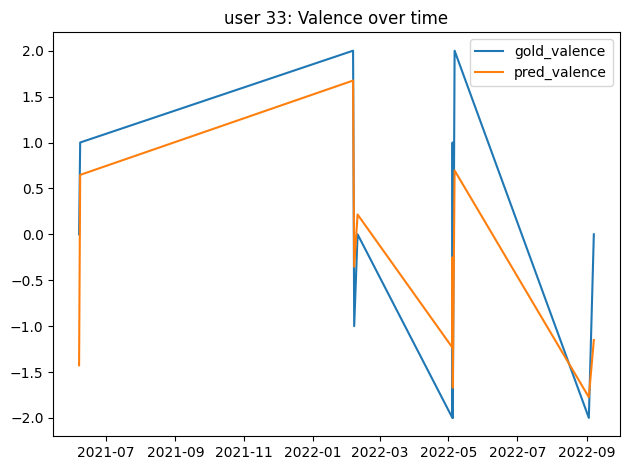

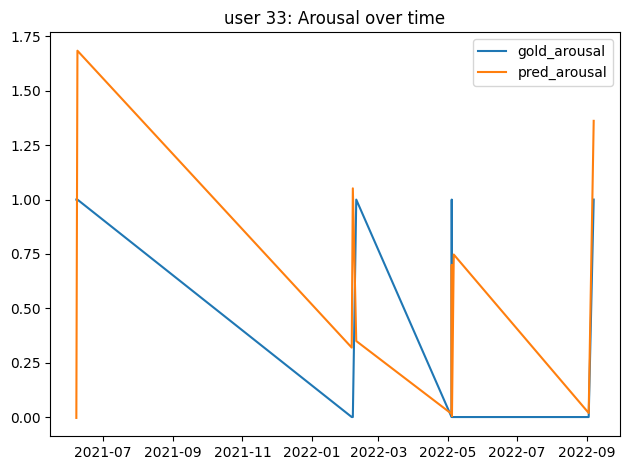

In [8]:
def plot_user(user_id):
    u = df[df["user_id"] == user_id].sort_values("timestamp").copy()
    plt.figure()
    plt.plot(u["timestamp"], u["valence"], label="gold_valence")
    plt.plot(u["timestamp"], u["pred_valence"], label="pred_valence")
    plt.title(f"user {user_id}: Valence over time")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.plot(u["timestamp"], u["arousal"], label="gold_arousal")
    plt.plot(u["timestamp"], u["pred_arousal"], label="pred_arousal")
    plt.title(f"user {user_id}: Arousal over time")
    plt.legend()
    plt.tight_layout()
    plt.show()

for uid in top_users:
    plot_user(uid)


In [9]:
st2a = df.sort_values(["user_id", "timestamp"]).copy()

st2a["pred_state_change_valence"] = st2a.groupby("user_id")["pred_valence"].shift(-1) - st2a["pred_valence"]
st2a["pred_state_change_arousal"] = st2a.groupby("user_id")["pred_arousal"].shift(-1) - st2a["pred_arousal"]

# gold dacă există în fișier (uneori nu e în ST1 file)
st2a["gold_state_change_valence"] = st2a.groupby("user_id")["valence"].shift(-1) - st2a["valence"]
st2a["gold_state_change_arousal"] = st2a.groupby("user_id")["arousal"].shift(-1) - st2a["arousal"]

# ultimele texte per user au NaN (corect)
out_cols = ["user_id","text_id","timestamp","collection_phase","is_words",
            "pred_valence","pred_arousal",
            "pred_state_change_valence","pred_state_change_arousal",
            "gold_state_change_valence","gold_state_change_arousal"]
out_cols = [c for c in out_cols if c in st2a.columns]

st2a_out = st2a[out_cols].copy()
st2a_out.to_csv(f"{OUTDIR}/st2a_from_st1_preds.csv", index=False)
st2a_out.head()


,user_id,text_id,timestamp,collection_phase,is_words,pred_valence,pred_arousal,pred_state_change_valence,pred_state_change_arousal,gold_state_change_valence,gold_state_change_arousal
131,1,200,2021-06-09 12:41:57,1,False,1.538038,0.800582,NaN,NaN,NaN,NaN
184,2,24,2021-06-11 17:10:13,1,True,0.962272,1.473571,1.114198,-1.078228,2.0,-2.0
7,2,36,2022-02-12 20:06:00,2,True,2.076470,0.395343,0.002715,-0.407151,0.0,0.0
241,2,37,2022-02-14 15:01:30,2,True,2.079185,-0.011808,0.031392,0.043480,0.0,0.0
128,2,38,2022-02-14 20:55:39,2,True,2.110577,0.031672,-0.875595,0.506045,0.0,0.0


In [10]:
# Pentru fiecare user: compari mean pe prima jumătate vs a doua jumătate (după timp)
tmp = df.sort_values(["user_id","timestamp"]).copy()

tmp["rank"] = tmp.groupby("user_id").cumcount()
tmp["n_user"] = tmp.groupby("user_id")["user_id"].transform("size")
tmp["group_half"] = np.where(tmp["rank"] < (tmp["n_user"] / 2.0), 1, 2)

agg = tmp.groupby(["user_id","group_half"]).agg(
    mean_pred_valence=("pred_valence","mean"),
    mean_pred_arousal=("pred_arousal","mean"),
    mean_gold_valence=("valence","mean"),
    mean_gold_arousal=("arousal","mean"),
    n=("user_id","size")
).reset_index()

half1 = agg[agg["group_half"]==1].set_index("user_id")
half2 = agg[agg["group_half"]==2].set_index("user_id")

st2b = half2[["mean_pred_valence","mean_pred_arousal","mean_gold_valence","mean_gold_arousal"]].copy()
st2b = st2b.rename(columns={
    "mean_pred_valence":"pred_mean_valence_half2",
    "mean_pred_arousal":"pred_mean_arousal_half2",
    "mean_gold_valence":"gold_mean_valence_half2",
    "mean_gold_arousal":"gold_mean_arousal_half2",
})
st2b["pred_mean_valence_half1"] = half1["mean_pred_valence"]
st2b["pred_mean_arousal_half1"] = half1["mean_pred_arousal"]
st2b["gold_mean_valence_half1"] = half1["mean_gold_valence"]
st2b["gold_mean_arousal_half1"] = half1["mean_gold_arousal"]

st2b["pred_disposition_change_valence"] = st2b["pred_mean_valence_half2"] - st2b["pred_mean_valence_half1"]
st2b["pred_disposition_change_arousal"] = st2b["pred_mean_arousal_half2"] - st2b["pred_mean_arousal_half1"]

st2b["gold_disposition_change_valence"] = st2b["gold_mean_valence_half2"] - st2b["gold_mean_valence_half1"]
st2b["gold_disposition_change_arousal"] = st2b["gold_mean_arousal_half2"] - st2b["gold_mean_arousal_half1"]

st2b = st2b.reset_index()
st2b.to_csv(f"{OUTDIR}/st2b_from_st1_preds.csv", index=False)
st2b.head()


,user_id,pred_mean_valence_half2,pred_mean_arousal_half2,gold_mean_valence_half2,gold_mean_arousal_half2,pred_mean_valence_half1,pred_mean_arousal_half1,gold_mean_valence_half1,gold_mean_arousal_half1,pred_disposition_change_valence,pred_disposition_change_arousal,gold_disposition_change_valence,gold_disposition_change_arousal
0,2,1.138718,0.160770,1.166667,0.166667,0.899902,0.324137,0.833333,0.333333,0.238816,-0.163367,0.333333,-0.166667
1,11,-0.593168,0.835177,-1.250000,0.750000,-0.083203,0.769783,0.500000,0.750000,-0.509965,0.065394,-1.750000,0.000000
2,16,0.219487,0.400469,-0.666667,0.000000,-0.587806,0.849145,0.250000,0.750000,0.807293,-0.448675,-0.916667,-0.750000
3,17,0.983024,0.896305,1.666667,0.333333,0.824237,0.819485,1.000000,0.666667,0.158787,0.076819,0.666667,-0.333333
4,21,1.199430,0.701401,2.000000,1.000000,0.970057,1.065417,2.000000,0.000000,0.229373,-0.364016,0.000000,1.000000


In [11]:
from scipy.stats import pearsonr

def pearson_safe(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    m = np.isfinite(a) & np.isfinite(b)
    if m.sum() < 5:
        return np.nan
    return pearsonr(a[m], b[m])[0]

# ST2A (exclude last per user)
a = st2a_out.dropna(subset=["pred_state_change_valence","gold_state_change_valence",
                             "pred_state_change_arousal","gold_state_change_arousal"])

p_v = pearson_safe(a["gold_state_change_valence"], a["pred_state_change_valence"])
p_a = pearson_safe(a["gold_state_change_arousal"], a["pred_state_change_arousal"])
print("ST2A pearson valence:", p_v, "arousal:", p_a, "mean:", np.nanmean([p_v,p_a]))

# ST2B
b = st2b.dropna(subset=["pred_disposition_change_valence","gold_disposition_change_valence",
                        "pred_disposition_change_arousal","gold_disposition_change_arousal"])

p_v2 = pearson_safe(b["gold_disposition_change_valence"], b["pred_disposition_change_valence"])
p_a2 = pearson_safe(b["gold_disposition_change_arousal"], b["pred_disposition_change_arousal"])
print("ST2B pearson valence:", p_v2, "arousal:", p_a2, "mean:", np.nanmean([p_v2,p_a2]))


ST2A pearson valence: 0.713871937504148 arousal: 0.48937347761995176 mean: 0.6016227075620499
ST2B pearson valence: 0.6092438291454769 arousal: 0.2833419307232284 mean: 0.4462928799343526
